In [19]:
import numpy as np
import pandas as pd
import datetime
import glob
import os
 

In [20]:
path = os.path.abspath(os.path.join( os.getcwd()   , 'log_files\\') ) 

log_files = glob.glob( path+ '*.csv')  

df = pd.DataFrame()
for file in log_files :
    df_temp = pd.read_csv( file, index_col=None, header=0)  
    df = df.append(df_temp ,sort=False)   
    
df.tail()

,date,start time,Task,Label,Duration (s)
20,2020/04/13,16:14:51,Common data folder,Timing feedforward project,1500
21,2020/04/13,16:39:52,Common data folder,Timing feedforward project,40
22,2020/04/13,16:40:44,empytTask,emptyLabel,0
23,2020/04/13,16:40:57,Coding organize,Timing feedforward project,185
24,2020/04/13,16:44:18,empytTask,emptyLabel,0


In [21]:
df['date'] = pd.to_datetime(df['date'] )  
df['Duration (hh:mm:ss)'] = pd.to_timedelta(df['Duration (s)'],'s')
df.tail()
df['Week'] = df['date'].dt.strftime("%V")

In [22]:
df_week = df.groupby(['Week','Label',]).sum()
df_week['Time spent per week'] = pd.to_timedelta(df_week['Duration (s)'],'s')
df_week =df_week.drop( ['Duration (s)'],axis=1) 
df_week

Time spent per week
Week Label                                         
13   Other                                 00:20:00
14   Other                                 00:15:00
15   Code                                  02:35:56
     FEA project                           01:24:21
     Jobsearch                             00:42:46
     Meetings                              03:01:44
     News                                  00:57:01
     Other                                 04:49:43
     Study                                 04:37:45
16   Code                                  01:45:02
     News                                  01:12:19
     Other                                 00:08:51
     Timing feedforward                    01:15:59
     Timing feedforward project            01:37:12
     emptyLabel                            00:00:00

In [23]:
df_day = df.groupby(['date','Label',]).sum()
df_day['Time spent per day'] = pd.to_timedelta(df_day['Duration (s)'],'s')
df_day =df_day.drop( ['Duration (s)'],axis=1) 
df_day

Time spent per day
date       Label                                        
2020-03-25 Other                                00:15:00
2020-03-27 Other                                00:05:00
2020-04-01 Other                                00:15:00
2020-04-08 Jobsearch                            00:00:05
           Meetings                             00:52:10
           Other                                00:59:06
2020-04-09 Jobsearch                            00:42:41
           Other                                01:15:00
           Study                                02:07:57
2020-04-10 FEA project                          01:24:21
           Meetings                             02:09:34
           Other                                02:12:49
           Study                                02:29:48
2020-04-11 Code                                 02:35:56
           News                                 00:39:53
           Other                                00:22:48
2020-04-12 News                                 00:17:08
2020-04-13 Code                                 01:45:02
           News                                 01:12:19
           Other                                00:08:51
           Timing feedforward                   01:15:59
           Timing feedforward project           01:37:12
           emptyLabel                           00:00:00

In [24]:
df_day.groupby('date').sum()

,Time spent per day
date,
2020-03-25,00:15:00
2020-03-27,00:05:00
2020-04-01,00:15:00
2020-04-08,01:51:21
2020-04-09,04:05:38
2020-04-10,08:16:32
2020-04-11,03:38:37
2020-04-12,00:17:08
2020-04-13,05:59:23


In [25]:
for day in df['date'].unique()[-2:]:
    print(day)
    bool_day = df['date'] == day
    
    df_temp = df[bool_day]
df_temp.tail()

2020-04-12T00:00:00.000000000
2020-04-13T00:00:00.000000000


,date,start time,Task,Label,Duration (s),Duration (hh:mm:ss),Week
20,2020-04-13,16:14:51,Common data folder,Timing feedforward project,1500,00:25:00,16
21,2020-04-13,16:39:52,Common data folder,Timing feedforward project,40,00:00:40,16
22,2020-04-13,16:40:44,empytTask,emptyLabel,0,00:00:00,16
23,2020-04-13,16:40:57,Coding organize,Timing feedforward project,185,00:03:05,16
24,2020-04-13,16:44:18,empytTask,emptyLabel,0,00:00:00,16


In [26]:
# plot parameters
 
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt


cols = np.array([[166,206,227], 
[31,120,180], 
[178,223,138], 
[51,160,44], 
[251,154,153], 
[227,26,28], 
[253,191,111], 
[255,127,0], 
[202,178,214], 
[106,61,154], 
[255,255,153]]) /255 
 
cmap = ListedColormap(cols) 

 
def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

 



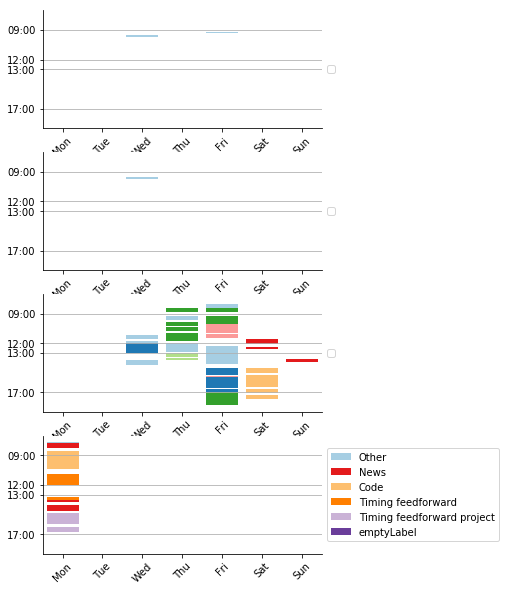

In [27]:


from matplotlib.ticker import MultipleLocator, FuncFormatter, NullFormatter
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

def tick(x,pos): 
        return days[int(x)]  
    
    

def hours_to_hhmm( arr ): 
    out_list = []
    for val in arr:
        if val< 10:
            test = '0' + str(val) +':00'
        else:
            test = str(val) + ':00'
        out_list.append(test)
    return( out_list ) 


days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
monthsFmt = DateFormatter("%a")
weeks = df['Week'].unique()

fig, ax = plt.subplots(len(weeks), 1, figsize =(5,10))

for i,week in enumerate(weeks): 
    bool_week = df['Week'] == week
    days_in_week = df.loc[bool_week,'date'].unique()
    for day in days_in_week : 
        bool_day = df['date'] == day 
        df_temp = df[bool_day] 

        for j,row in df_temp.iterrows():
            y = get_sec( row['start time'] )
            dy =  row['Duration (s)'] 
            label = row['Label'] 
            col_ind = np.where( df['Label'].unique() == label )[0][0] 

            ax[i].bar( row['date'],dy, bottom = y, color = cols[col_ind] , label = label ) 

 

    first_day = pd.to_datetime( days_in_week[0] )
    mon_day = first_day - datetime.timedelta( first_day.isocalendar()[2] -0.5 )
    sun_day = mon_day + datetime.timedelta( 7)
    ax[i].set_xlim([mon_day,sun_day])

    hours = np.array([9,12,13,17])
    
    ax[i].yaxis.set_ticks( hours*3600)
    ax[i].yaxis.set_ticklabels( hours_to_hhmm(hours ) )
    ax[i].yaxis.grid('on')

    ax[i].set_ylim([7*3600,19*3600]) 
    ax[i].xaxis.set_major_locator(MultipleLocator(1))
    ax[i].xaxis.set_major_formatter(monthsFmt) 
    for tick in ax[i].get_xticklabels():
        tick.set_rotation( 45 )
        
    ax[i].set_xlim()
    ax[i].invert_yaxis()
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
#     ax[i].spines['left'].set_visible(False)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[i].legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5) )

In [28]:
weeks

array(['13', '14', '15', '16'], dtype=object)

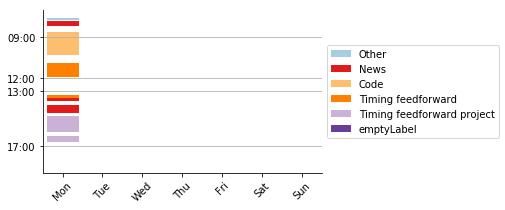

In [29]:
fig, ax = plt.subplots(1, 1, figsize =(5,3))
 
bool_week = df['Week'] == weeks[-1]
days_in_week = df.loc[bool_week,'date'].unique()
for day in days_in_week : 
    bool_day = df['date'] == day 
    df_temp = df[bool_day] 

    for j,row in df_temp.iterrows():
        y = get_sec( row['start time'] )
        dy =  row['Duration (s)'] 
        label = row['Label'] 
        col_ind = np.where( df['Label'].unique() == label )[0][0] 

        ax.bar( row['date'],dy, bottom = y, color = cols[col_ind] , label = label ) 
 
first_day = pd.to_datetime( days_in_week[0] )
mon_day = first_day - datetime.timedelta( first_day.isocalendar()[2] -0.5 )
sun_day = mon_day + datetime.timedelta( 7)
ax.set_xlim([mon_day,sun_day])

hours = np.array([9,12,13,17])

ax.yaxis.set_ticks( hours*3600)
ax.yaxis.set_ticklabels( hours_to_hhmm(hours ) )
ax.yaxis.grid('on')

ax.set_ylim([7*3600,19*3600]) 
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(monthsFmt) 
for tick in ax.get_xticklabels():
    tick.set_rotation( 45 )

ax.set_xlim()
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5) )


# fig_name= 'example_week' 
# save_fig = True
# if save_fig: 
#     plt.savefig('./figs/' + fig_name + '.png',
#             format='png', dpi=300,
#             transparent=  True,             
#             bbox_inches = 'tight', pad_inches = 0,
#             )  